In [1]:
pip install statsforecast datasetsforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.1/319.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.6/275.6 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 8.8 MB/s eta 0:00:00


In [2]:
pip install utilsforecast

In [3]:
import argparse
import os
import random
from functools import partial
from pathlib import Path

import pandas as pd
from datasetsforecast.m4 import M4, M4Info

from statsforecast import StatsForecast
from statsforecast.models import (
    AutoMFLES,
)


# data
seasonality_overrides = {
    "Hourly": [24, 24*7],
}
group = 'Hourly'
df, *_ = M4.load("data", group)
df['ds'] = df['ds'].astype('int64')
info = M4Info['Hourly']
h = info.horizon
season_length = [info.seasonality]
if group in seasonality_overrides:
    season_length = seasonality_overrides[group]
valid = df.groupby("unique_id").tail(h)
train = df.drop(valid.index)
print(f'Running {group}. season_length: {season_length}')

# forecast
sf = StatsForecast(
    models=[
        AutoMFLES(test_size=h, season_length=season_length, n_windows=3),
    ],
    freq=1,
    n_jobs=-1,
    verbose=True,
)
preds = sf.forecast(df=train, h=h)
res = preds.merge(valid, on=['unique_id', 'ds'])

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
2.35MiB [00:00, 32.1MiB/s]                 
ERROR:datasetsforecast.utils:ERROR, something went wrong downloading data
133kiB [00:00, 16.2MiB/s]                   
ERROR:datasetsforecast.utils:ERROR, something went wrong downloading data
4.34MiB [00:00, 60.1MiB/s]                 
ERROR:datasetsforecast.utils:ERROR, something went wrong downloading data
100%|██████████| 3.56M/3.56M [00:00<00:00, 30.7MiB/s]


Running Hourly. season_length: [24, 168]


Forecast:   0%|          | 0/200 [Elapsed: 00:00]

In [4]:
from functools import partial
from pathlib import Path

import pandas as pd
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import smape, mape, rmse, mae, mase


def generate_metrics(train, valid) -> str:
    seasonalities = {
        'hourly': 24,
        'daily': 7,
        'weekly': 52,
        'monthly': 12,
        'quarterly': 4,
        'yearly': 1,
    }
    fmts = {
        'mase': '{:.2f}',
        'rmse': '{:,.1f}',
        'smape': '{:.1%}',
        'mape': '{:.1%}',
        'mae': '{:,.1f}',
    }
    season_length = 24
    pmase = partial(mase, seasonality=season_length)


    eval_res = evaluate(
        valid,
        train_df=train,
        metrics=[smape, mape, rmse, mae, pmase],
    )

    return eval_res

In [5]:
metrics = generate_metrics(train, res)

In [6]:
metrics

,unique_id,metric,AutoMFLES
0,H1,smape,0.019827
1,H10,smape,0.011146
2,H100,smape,0.059969
3,H101,smape,0.011136
4,H102,smape,0.056417
...,...,...,...
2065,H95,mase,1.332917
2066,H96,mase,2.865115
2067,H97,mase,0.550488
2068,H98,mase,0.534029


In [7]:
metrics = metrics.pivot_table(index='unique_id', columns='metric', values='AutoMFLES')

In [8]:
metrics

metric,mae,mape,mase,rmse,smape
unique_id,,,,,
H1,26.902167,0.038546,0.634915,37.758502,0.019827
H10,10.304390,0.021956,0.978888,13.854254,0.011146
H100,123.754086,0.112711,0.845011,172.055630,0.059969
H101,49.680711,0.022029,0.244089,61.868410,0.011136
H102,212.632296,0.104056,0.982706,259.902782,0.056417
...,...,...,...,...,...
H95,5512.114882,0.061781,1.332917,6437.995356,0.029679
H96,863.327847,0.164977,2.865115,901.263478,0.090270
H97,904.446926,0.020205,0.550488,1101.652714,0.009991


In [9]:
metrics['mape_mean'] = metrics['mape'].mean()
metrics['smape_mean'] = metrics['smape'].mean()
metrics['rmse_mean'] = metrics['rmse'].mean()
metrics['mae_mean'] = metrics['mae'].mean()
metrics['mase_mean'] = metrics['mase'].mean()

In [10]:
mape_greater = metrics[(metrics['mape'] > metrics['mape_mean']) & (metrics['rmse'] > metrics['rmse_mean']) & (metrics['mae'] > metrics['mae_mean']) & (metrics['mase'] < metrics['mase_mean'])]

In [11]:
mape_greater

metric,mae,mape,mase,rmse,smape,mape_mean,smape_mean,rmse_mean,mae_mean,mase_mean
unique_id,,,,,,,,,,
H151,342.945198,0.522401,1.384503,626.466781,0.215351,0.121247,0.058408,362.971365,299.64411,1.79335
H158,450.889095,0.291698,1.107646,797.839698,0.157310,0.121247,0.058408,362.971365,299.64411,1.79335
H161,382.207623,0.176849,0.975148,516.131123,0.080792,0.121247,0.058408,362.971365,299.64411,1.79335
H164,310.657992,0.198449,0.908817,476.820400,0.093390,0.121247,0.058408,362.971365,299.64411,1.79335


In [12]:
mase_greater = metrics[(metrics['mape'] < metrics['mape_mean']) & (metrics['rmse'] < metrics['rmse_mean']) & (metrics['mae'] < metrics['mae_mean'])  & (metrics['mase'] > metrics['mase_mean'])]

In [13]:
mase_greater

metric,mae,mape,mase,rmse,smape,mape_mean,smape_mean,rmse_mean,mae_mean,mase_mean
unique_id,,,,,,,,,,
H170,0.446572,0.020282,2.474783,0.504162,0.010136,0.121247,0.058408,362.971365,299.64411,1.79335
H172,0.639901,0.029920,4.473096,0.732926,0.014959,0.121247,0.058408,362.971365,299.64411,1.79335
H173,0.491201,0.023333,3.423410,0.557581,0.011704,0.121247,0.058408,362.971365,299.64411,1.79335
H175,0.433996,0.020182,3.168647,0.554755,0.010033,0.121247,0.058408,362.971365,299.64411,1.79335
H176,0.333436,0.015261,2.018732,0.421789,0.007568,0.121247,0.058408,362.971365,299.64411,1.79335
...,...,...,...,...,...,...,...,...,...,...
H321,0.089461,0.004084,3.322833,0.104019,0.002047,0.121247,0.058408,362.971365,299.64411,1.79335
H323,0.385712,0.018410,2.306881,0.438568,0.009260,0.121247,0.058408,362.971365,299.64411,1.79335
H324,0.402649,0.018269,2.984005,0.465331,0.009078,0.121247,0.058408,362.971365,299.64411,1.79335


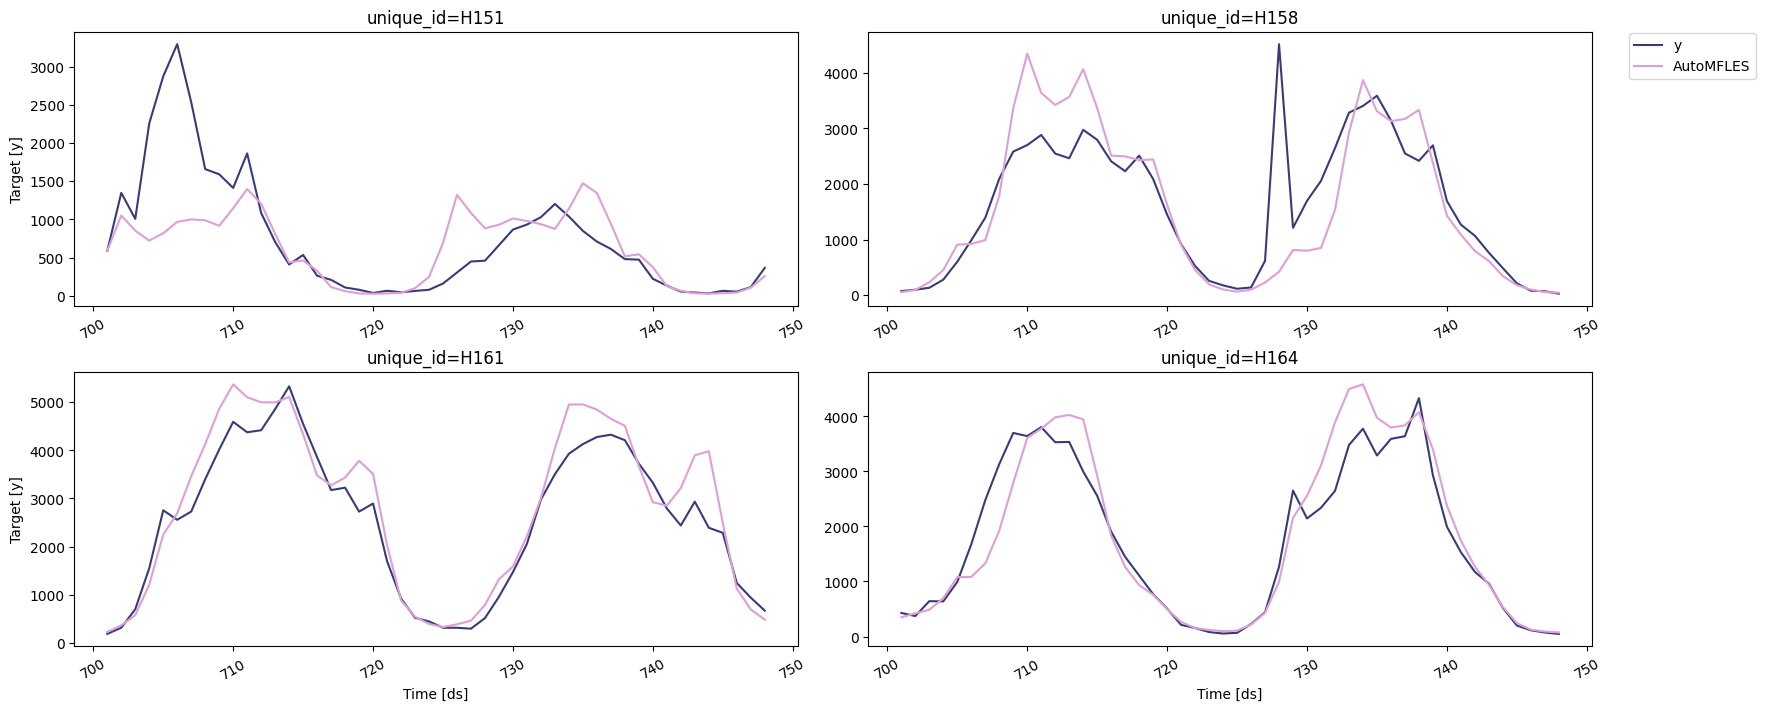

In [14]:
sf.plot(res[res['unique_id'].isin(mape_greater.index)],preds[preds['unique_id'].isin(mape_greater.index)], plot_random=False)

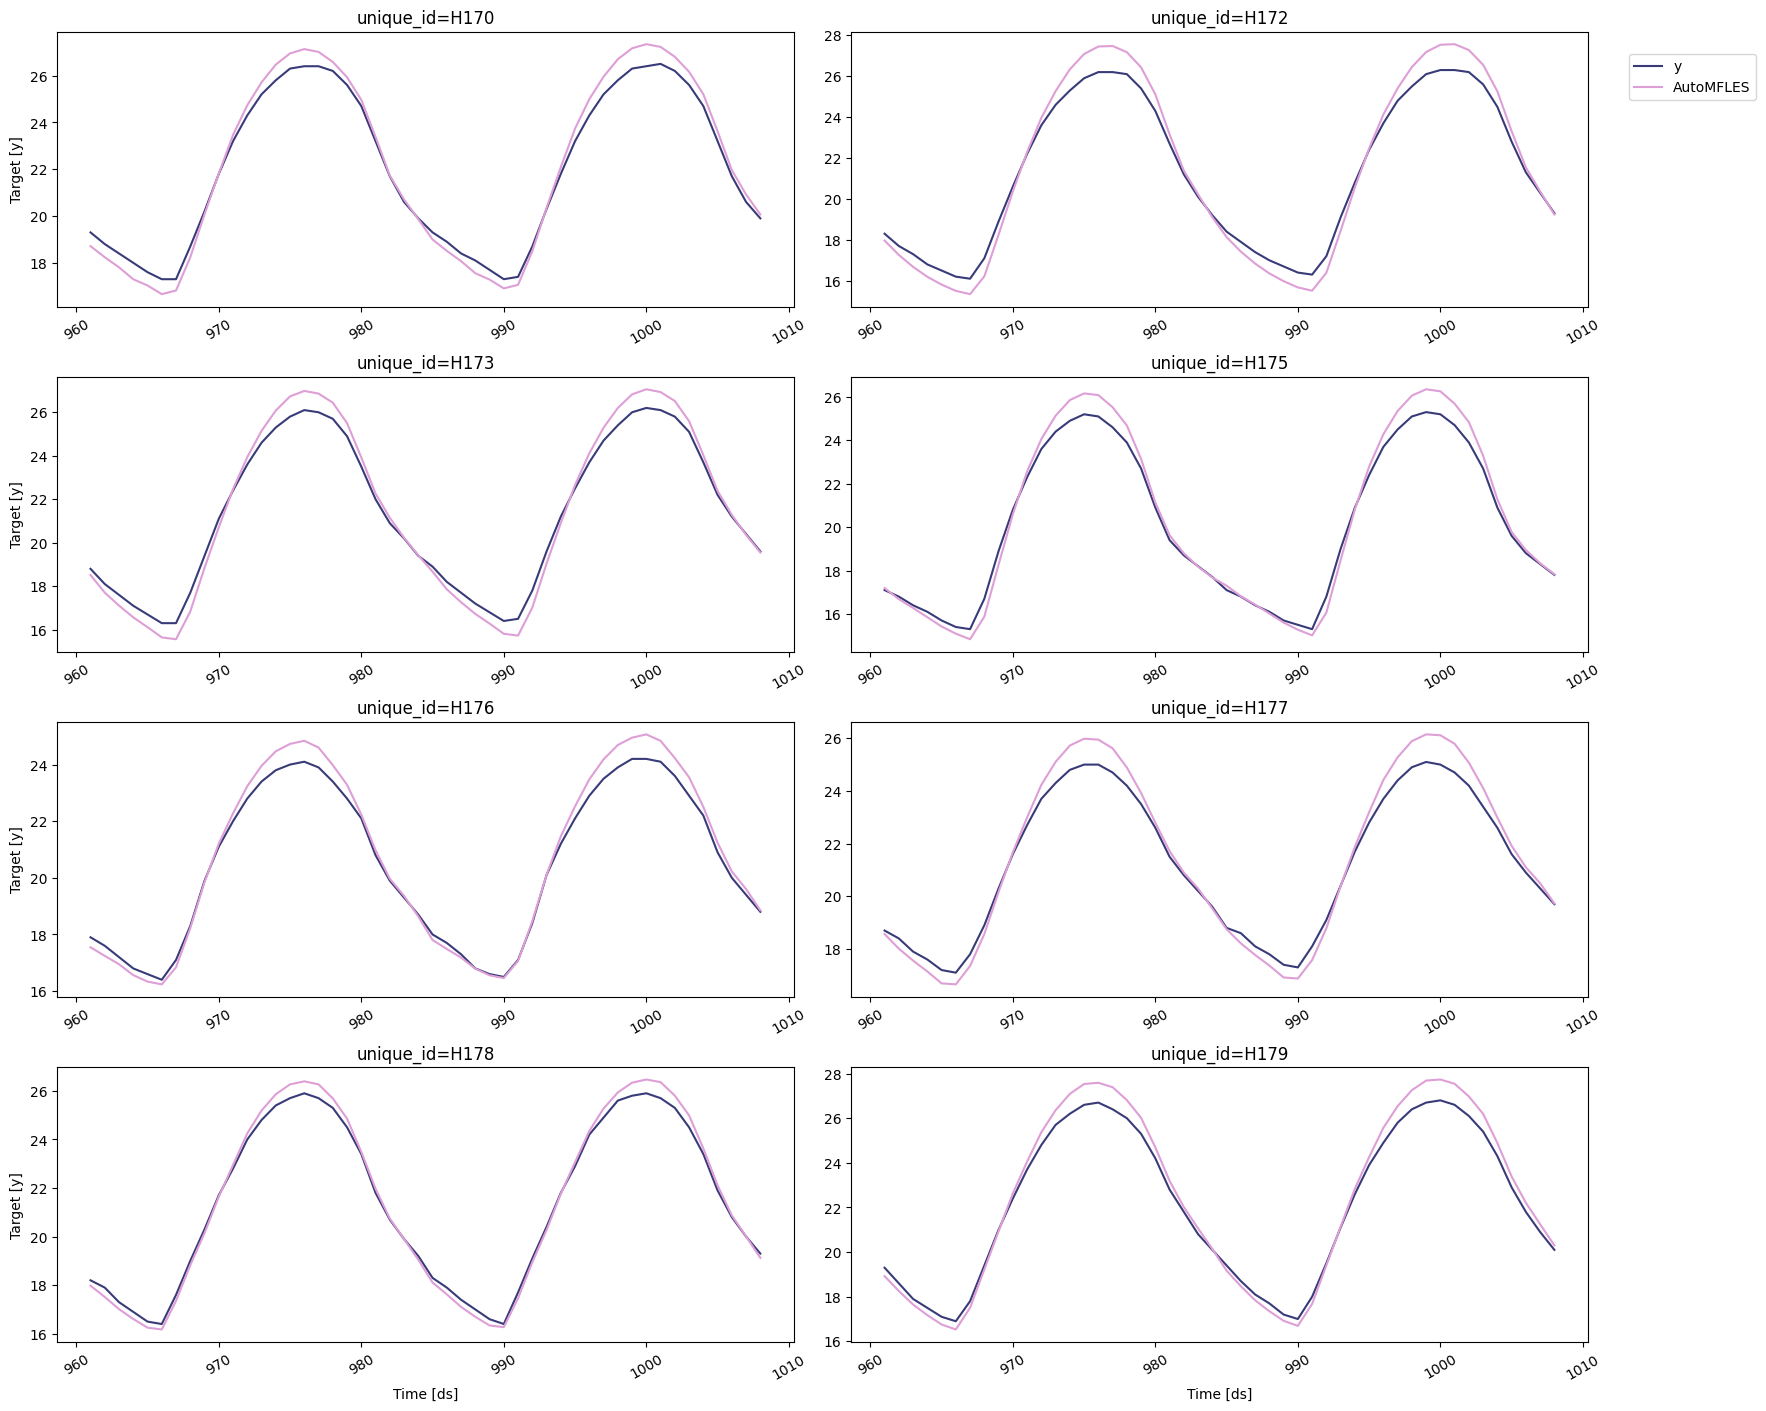

In [15]:
sf.plot(res[res['unique_id'].isin(mase_greater.index)],preds[preds['unique_id'].isin(mase_greater.index)], plot_random=False)